In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
import vb_lib.structure_optimization_lib as str_opt_lib

import paragami
import vittles

from copy import deepcopy

import argparse
import distutils.util

import os

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 40
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

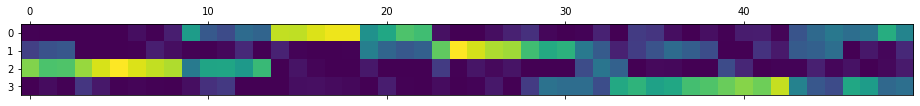

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs.shape

(50, 40, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = 12

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (40, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (50, 11, 2) (lb=0.0, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                use_logitnormal_sticks)

init_vb_params_dict = deepcopy(vb_params_dict)

In [12]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_opt_dict['ind_mix_stick_propn_mean'], 
                            vb_opt_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

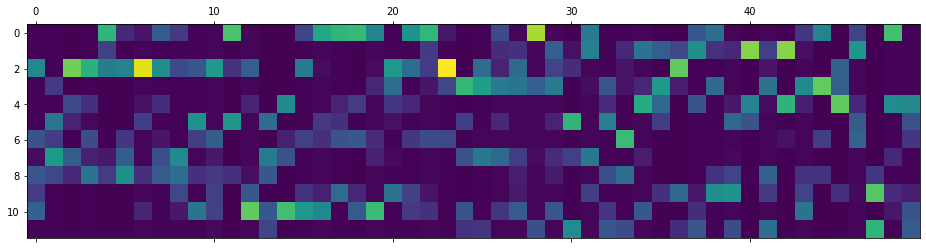

In [13]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())

# Run CAVI

In [14]:
# get parameters for sticks and populations
ez_opt, vb_opt_dict, kl_vec, _ = \
    cavi_lib.run_cavi(g_obs, vb_params_dict, 
                        prior_params_dict,
                        use_logitnormal_sticks, 
                        max_iter = 1000,
                        f_tol = 1e-4)


iteration [1]; kl:5808.827066; elapsed: 0.0141secs
iteration [2]; kl:4566.250954; elapsed: 0.0138secs
iteration [3]; kl:4330.351941; elapsed: 0.0137secs
iteration [4]; kl:4267.947915; elapsed: 0.0138secs
iteration [5]; kl:4229.534239; elapsed: 0.0135secs
iteration [6]; kl:4196.291868; elapsed: 0.0141secs
iteration [7]; kl:4164.797523; elapsed: 0.0135secs
iteration [8]; kl:4133.915619; elapsed: 0.0135secs
iteration [9]; kl:4103.219158; elapsed: 0.0135secs
iteration [10]; kl:4072.657477; elapsed: 0.0134secs
iteration [11]; kl:4042.420864; elapsed: 0.0132secs
iteration [12]; kl:4012.842137; elapsed: 0.0133secs
iteration [13]; kl:3984.336632; elapsed: 0.0132secs
iteration [14]; kl:3957.364863; elapsed: 0.0149secs
iteration [15]; kl:3932.400452; elapsed: 0.0168secs
iteration [16]; kl:3909.887328; elapsed: 0.0162secs
iteration [17]; kl:3890.036242; elapsed: 0.0134secs
iteration [18]; kl:3872.651069; elapsed: 0.0133secs
iteration [19]; kl:3857.274965; elapsed: 0.0132secs
iteration [20]; kl:38

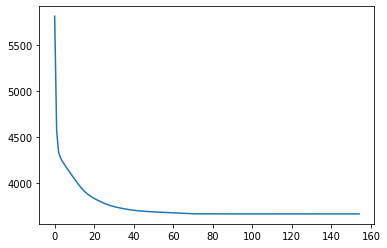

In [15]:
plt.plot(kl_vec)

In [16]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

In [17]:
objective = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

objective_fun = lambda x, y: objective(g_obs, x, y, use_logitnormal_sticks = False)


In [18]:
import scipy as osp

In [19]:
continue_with_newton = False

if continue_with_newton: 
    
    get_loss = lambda x : objective_fun(x, prior_params_free)
    get_loss_objective = paragami.OptimizationObjective(get_loss)
    
    res = osp.optimize.minimize(
                fun=get_loss_objective.f,
                jac=get_loss_objective.grad,
                hess=get_loss_objective.hessian,
                x0=vb_params_paragami.flatten(vb_params_dict, free = True),
                method='trust-exact', options={'disp':True})
    
    
    print('\nlinf diff in vb_params: ', np.abs(res.x - vb_opt).max())
    
    vb_opt = deepcopy(res.x)
    vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
    ez_opt = str_opt_lib.get_e_z_from_vb_params_dict(g_obs, vb_opt_dict, use_logitnormal_sticks)


# Check results

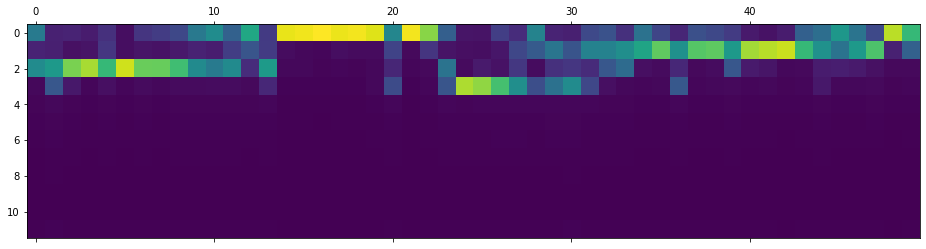

In [20]:
plt.matshow(get_vb_expectations(vb_opt_dict, use_logitnormal_sticks)[0].transpose())

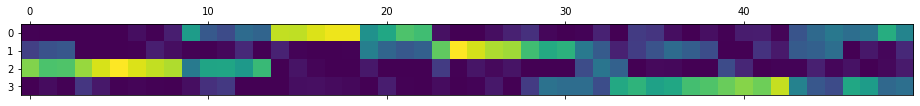

In [21]:
plt.matshow(true_ind_admix_propn.transpose())

# Check optimum

In [22]:
# get hessian 
t0 = time.time()
# get_hess = autograd.hessian(objective_fun, argnum = 0)
# hessian_at_opt = get_hess(vb_opt, prior_params_free)

#  print('hessian time: {}sec'.format(np.round(time.time() - t0, 3)))
# hess_solver = vittles.solver_lib.get_cholesky_solver(hessian_at_opt)

objective_fun_hvp = autograd.hessian_vector_product(objective_fun, argnum = 0)
hess_solver = vittles.solver_lib.get_cg_solver(lambda x : objective_fun_hvp(vb_opt, prior_params_free, x),
                                 dim = len(vb_opt))

In [23]:
# gradient 
get_objective_grad = autograd.jacobian(objective_fun, argnum = 0)

In [24]:
optimum_checker = vittles.bivariate_sensitivity_lib.OptimumChecker(
                                                estimating_equation = get_objective_grad, 
                                                solver = hess_solver, 
                                                input_base = vb_opt, 
                                                hyper_base = prior_params_free)


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/vittles/bivariate_sensitivity_lib.py:32: UserWarning: The CrossSensitivity class is very experimental and untested.
  warnings.warn(


In [25]:
newton_step = optimum_checker.get_newton_step()

In [26]:
np.abs(newton_step).max()

0.07647901179275465

# Parametric sensitivity

### Hyper parameter sensitivity object

In [27]:
# vb_sens = \
#     vittles.HyperparameterSensitivityLinearApproximation(
#         objective_fun = objective_fun, 
#         opt_par_value = vb_opt, 
#         hyper_par_value = prior_params_free, 
#         hessian_at_opt = hessian_at_opt)

vb_sens = \
    vittles.ParametricSensitivityTaylorExpansion(
        estimating_equation = get_objective_grad, 
        input_val0 = vb_opt, 
        hyper_val0 = prior_params_free, 
        order = 1, 
        hess_solver = hess_solver)


### Set new prior

In [28]:
new_alpha = np.array([4.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['dp_prior_alpha'] = new_alpha


In [29]:
print('initial alpha, ', prior_params_dict['dp_prior_alpha'])
print('perturbed alpha, ', prior_params_pert_dict['dp_prior_alpha'])

initial alpha,  [3.]
perturbed alpha,  [4.]


In [30]:
# lr_vb_free_params = \
#     vb_sens.predict_opt_par_from_hyper_par(
#         prior_params_paragami.flatten(prior_params_pert_dict, free = True))

lr_vb_free_params = \
    vb_sens.evaluate_taylor_series(
        prior_params_paragami.flatten(prior_params_pert_dict, free = True))

In [31]:
print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))


l_inf diff:  0.6653037145834191


In [32]:
vb_opt

array([3.31581665, 2.30432607, 2.55130716, ..., 1.18613212, 0.04717559,
       1.17126954])

In [33]:
lr_vb_free_params

array([3.28382147, 2.21766596, 2.54376835, ..., 1.55835301, 0.09200184,
       1.53449856])

### Re-optimize

In [34]:
new_init_dict = deepcopy(vb_opt_dict)
# new_init_dict = deepcopy(init_vb_params_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)


In [35]:
# get beta parameters for sticks and populations
ez_pert, vb_pert_dict, _, _ = \
    cavi_lib.run_cavi(g_obs, new_init_dict, 
                        prior_params_pert_dict,
                        use_logitnormal_sticks, 
                        max_iter = 1000,
                        f_tol = 1e-4)


iteration [1]; kl:3918.762767; elapsed: 0.0222secs
iteration [2]; kl:3910.834645; elapsed: 0.0173secs
iteration [3]; kl:3908.710374; elapsed: 0.0134secs
iteration [4]; kl:3907.865687; elapsed: 0.0131secs
iteration [5]; kl:3907.459554; elapsed: 0.0131secs
iteration [6]; kl:3907.23779; elapsed: 0.0131secs
iteration [7]; kl:3907.104167; elapsed: 0.0132secs
iteration [8]; kl:3907.016851; elapsed: 0.0133secs
iteration [9]; kl:3906.955792; elapsed: 0.0131secs
iteration [10]; kl:3906.910626; elapsed: 0.0132secs
iteration [11]; kl:3906.875652; elapsed: 0.0132secs
iteration [12]; kl:3906.847565; elapsed: 0.0147secs
iteration [13]; kl:3906.824353; elapsed: 0.0187secs
iteration [14]; kl:3906.804737; elapsed: 0.0141secs
iteration [15]; kl:3906.787872; elapsed: 0.0132secs
iteration [16]; kl:3906.773179; elapsed: 0.0138secs
iteration [17]; kl:3906.760247; elapsed: 0.0133secs
iteration [18]; kl:3906.748773; elapsed: 0.0132secs
iteration [19]; kl:3906.738529; elapsed: 0.0133secs
iteration [20]; kl:390

In [36]:
vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)

### Compare lr vs reoptimizing

In [37]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


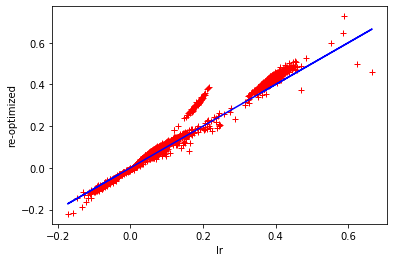

In [38]:
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [39]:
objective_fun(lr_vb_free_params, prior_params_paragami.flatten(prior_params_pert_dict, free = True))

3906.9562413321937

In [40]:
objective_fun(vb_opt_pert, prior_params_paragami.flatten(prior_params_pert_dict, free = True))

3906.6345322583543

# Fit for a range of alpha

In [41]:
alpha_list = np.arange(1, 15)

In [42]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha

    # get beta parameters for sticks and populations
    ez_pert, vb_pert_dict, _, _ = \
        cavi_lib.run_cavi(g_obs, new_init_dict, 
                            prior_params_pert_dict,
                            use_logitnormal_sticks, 
                            max_iter = 1000,
                            f_tol = 1e-4, 
                             print_every = 1e16)

    vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)   
        
    return vb_opt_pert


In [43]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\nre-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, new_init_dict))



re-optimzing with alpha =  1
iteration [1]; kl:3108.192273; elapsed: 0.0149secs
iteration [2]; kl:2946.17398; elapsed: 0.0148secs
iteration [3]; kl:2899.156811; elapsed: 0.0131secs
iteration [4]; kl:2885.168523; elapsed: 0.013secs
iteration [5]; kl:2879.214315; elapsed: 0.0135secs
iteration [6]; kl:2876.008771; elapsed: 0.013secs
iteration [7]; kl:2873.989815; elapsed: 0.0173secs
iteration [8]; kl:2872.578375; elapsed: 0.0157secs
iteration [9]; kl:2871.516304; elapsed: 0.0158secs
iteration [10]; kl:2870.678441; elapsed: 0.0132secs
iteration [11]; kl:2870.005068; elapsed: 0.0132secs
iteration [12]; kl:2869.465323; elapsed: 0.013secs
iteration [13]; kl:2869.034295; elapsed: 0.013secs
iteration [14]; kl:2868.686163; elapsed: 0.013secs
iteration [15]; kl:2868.397911; elapsed: 0.0136secs
iteration [16]; kl:2868.152176; elapsed: 0.0136secs
iteration [17]; kl:2867.936857; elapsed: 0.0131secs
iteration [18]; kl:2867.743765; elapsed: 0.013secs
iteration [19]; kl:2867.567407; elapsed: 0.0132sec

iteration [166]; kl:2861.476227; elapsed: 0.0139secs
iteration [167]; kl:2861.47485; elapsed: 0.0136secs
iteration [168]; kl:2861.473596; elapsed: 0.0134secs
iteration [169]; kl:2861.47245; elapsed: 0.0134secs
iteration [170]; kl:2861.471397; elapsed: 0.0131secs
iteration [171]; kl:2861.470425; elapsed: 0.0131secs
iteration [172]; kl:2861.469523; elapsed: 0.0131secs
iteration [173]; kl:2861.46868; elapsed: 0.0131secs
iteration [174]; kl:2861.467889; elapsed: 0.0131secs
iteration [175]; kl:2861.467142; elapsed: 0.0131secs
iteration [176]; kl:2861.466432; elapsed: 0.0132secs
iteration [177]; kl:2861.465755; elapsed: 0.0131secs
iteration [178]; kl:2861.465106; elapsed: 0.013secs
iteration [179]; kl:2861.46448; elapsed: 0.013secs
iteration [180]; kl:2861.463874; elapsed: 0.013secs
iteration [181]; kl:2861.463285; elapsed: 0.013secs
iteration [182]; kl:2861.462711; elapsed: 0.0136secs
iteration [183]; kl:2861.462148; elapsed: 0.0137secs
iteration [184]; kl:2861.461596; elapsed: 0.0133secs
i

iteration [20]; kl:3343.117166; elapsed: 0.0142secs
iteration [21]; kl:3343.089292; elapsed: 0.0137secs
iteration [22]; kl:3343.063669; elapsed: 0.0135secs
iteration [23]; kl:3343.040046; elapsed: 0.0135secs
iteration [24]; kl:3343.018208; elapsed: 0.0132secs
iteration [25]; kl:3342.997975; elapsed: 0.0133secs
iteration [26]; kl:3342.979187; elapsed: 0.0133secs
iteration [27]; kl:3342.961707; elapsed: 0.0134secs
iteration [28]; kl:3342.945416; elapsed: 0.0134secs
iteration [29]; kl:3342.930208; elapsed: 0.0133secs
iteration [30]; kl:3342.915989; elapsed: 0.0133secs
iteration [31]; kl:3342.902677; elapsed: 0.0134secs
iteration [32]; kl:3342.890198; elapsed: 0.0135secs
iteration [33]; kl:3342.878484; elapsed: 0.0134secs
iteration [34]; kl:3342.867478; elapsed: 0.0132secs
iteration [35]; kl:3342.857124; elapsed: 0.0134secs
iteration [36]; kl:3342.847375; elapsed: 0.0141secs
iteration [37]; kl:3342.838186; elapsed: 0.0132secs
iteration [38]; kl:3342.829518; elapsed: 0.0133secs
iteration [3

iteration [47]; kl:3663.088758; elapsed: 0.0183secs
iteration [48]; kl:3663.076; elapsed: 0.0153secs
iteration [49]; kl:3663.063492; elapsed: 0.0133secs
iteration [50]; kl:3663.05123; elapsed: 0.013secs
iteration [51]; kl:3663.039213; elapsed: 0.013secs
iteration [52]; kl:3663.027435; elapsed: 0.013secs
iteration [53]; kl:3663.015896; elapsed: 0.013secs
iteration [54]; kl:3663.004591; elapsed: 0.013secs
iteration [55]; kl:3662.993518; elapsed: 0.013secs
iteration [56]; kl:3662.982675; elapsed: 0.013secs
iteration [57]; kl:3662.97206; elapsed: 0.013secs
iteration [58]; kl:3662.961669; elapsed: 0.0131secs
iteration [59]; kl:3662.951501; elapsed: 0.013secs
iteration [60]; kl:3662.941553; elapsed: 0.013secs
iteration [61]; kl:3662.931823; elapsed: 0.013secs
iteration [62]; kl:3662.922307; elapsed: 0.013secs
iteration [63]; kl:3662.913003; elapsed: 0.0134secs
iteration [64]; kl:3662.903909; elapsed: 0.0132secs
iteration [65]; kl:3662.89502; elapsed: 0.0132secs
iteration [66]; kl:3662.886333

iteration [10]; kl:3906.943728; elapsed: 0.0299secs
iteration [11]; kl:3906.906582; elapsed: 0.0307secs
iteration [12]; kl:3906.876451; elapsed: 0.0206secs
iteration [13]; kl:3906.851318; elapsed: 0.0167secs
iteration [14]; kl:3906.829901; elapsed: 0.014secs
iteration [15]; kl:3906.811348; elapsed: 0.0131secs
iteration [16]; kl:3906.795074; elapsed: 0.0156secs
iteration [17]; kl:3906.780662; elapsed: 0.0133secs
iteration [18]; kl:3906.767803; elapsed: 0.0131secs
iteration [19]; kl:3906.756264; elapsed: 0.0155secs
iteration [20]; kl:3906.745864; elapsed: 0.0131secs
iteration [21]; kl:3906.736456; elapsed: 0.0132secs
iteration [22]; kl:3906.727921; elapsed: 0.0133secs
iteration [23]; kl:3906.72016; elapsed: 0.0137secs
iteration [24]; kl:3906.71309; elapsed: 0.0134secs
iteration [25]; kl:3906.706639; elapsed: 0.0132secs
iteration [26]; kl:3906.700746; elapsed: 0.0131secs
iteration [27]; kl:3906.695355; elapsed: 0.0132secs
iteration [28]; kl:3906.69042; elapsed: 0.0132secs
iteration [29]; 

iteration [30]; kl:4250.668454; elapsed: 0.0134secs
iteration [31]; kl:4250.622888; elapsed: 0.0135secs
iteration [32]; kl:4250.578242; elapsed: 0.0137secs
iteration [33]; kl:4250.53437; elapsed: 0.0132secs
iteration [34]; kl:4250.491141; elapsed: 0.013secs
iteration [35]; kl:4250.448441; elapsed: 0.0131secs
iteration [36]; kl:4250.406165; elapsed: 0.0132secs
iteration [37]; kl:4250.364222; elapsed: 0.013secs
iteration [38]; kl:4250.322528; elapsed: 0.0131secs
iteration [39]; kl:4250.281011; elapsed: 0.0131secs
iteration [40]; kl:4250.239605; elapsed: 0.0131secs
iteration [41]; kl:4250.198252; elapsed: 0.013secs
iteration [42]; kl:4250.1569; elapsed: 0.0131secs
iteration [43]; kl:4250.115505; elapsed: 0.0142secs
iteration [44]; kl:4250.074029; elapsed: 0.0171secs
iteration [45]; kl:4250.032438; elapsed: 0.0136secs
iteration [46]; kl:4249.990707; elapsed: 0.0134secs
iteration [47]; kl:4249.948814; elapsed: 0.0131secs
iteration [48]; kl:4249.906741; elapsed: 0.0132secs
iteration [49]; kl

iteration [200]; kl:4246.140465; elapsed: 0.0136secs
iteration [201]; kl:4246.133232; elapsed: 0.0132secs
iteration [202]; kl:4246.12624; elapsed: 0.0132secs
iteration [203]; kl:4246.119482; elapsed: 0.0131secs
iteration [204]; kl:4246.112951; elapsed: 0.0131secs
iteration [205]; kl:4246.10664; elapsed: 0.0131secs
iteration [206]; kl:4246.100543; elapsed: 0.0131secs
iteration [207]; kl:4246.094654; elapsed: 0.0131secs
iteration [208]; kl:4246.088966; elapsed: 0.0131secs
iteration [209]; kl:4246.083473; elapsed: 0.0132secs
iteration [210]; kl:4246.078169; elapsed: 0.0132secs
iteration [211]; kl:4246.073049; elapsed: 0.0131secs
iteration [212]; kl:4246.068106; elapsed: 0.0131secs
iteration [213]; kl:4246.063336; elapsed: 0.0131secs
iteration [214]; kl:4246.058733; elapsed: 0.0131secs
iteration [215]; kl:4246.054292; elapsed: 0.0131secs
iteration [216]; kl:4246.050008; elapsed: 0.0136secs
iteration [217]; kl:4246.045875; elapsed: 0.0133secs
iteration [218]; kl:4246.04189; elapsed: 0.0132s

iteration [41]; kl:4358.636441; elapsed: 0.0136secs
iteration [42]; kl:4358.630112; elapsed: 0.0132secs
iteration [43]; kl:4358.624222; elapsed: 0.0132secs
iteration [44]; kl:4358.618725; elapsed: 0.013secs
iteration [45]; kl:4358.613584; elapsed: 0.013secs
iteration [46]; kl:4358.608764; elapsed: 0.013secs
iteration [47]; kl:4358.604235; elapsed: 0.0131secs
iteration [48]; kl:4358.599968; elapsed: 0.0129secs
iteration [49]; kl:4358.595939; elapsed: 0.0129secs
iteration [50]; kl:4358.592126; elapsed: 0.0129secs
iteration [51]; kl:4358.588511; elapsed: 0.013secs
iteration [52]; kl:4358.585074; elapsed: 0.0129secs
iteration [53]; kl:4358.5818; elapsed: 0.013secs
iteration [54]; kl:4358.578676; elapsed: 0.0129secs
iteration [55]; kl:4358.575687; elapsed: 0.0129secs
iteration [56]; kl:4358.572823; elapsed: 0.0129secs
iteration [57]; kl:4358.570072; elapsed: 0.0133secs
iteration [58]; kl:4358.567427; elapsed: 0.0132secs
iteration [59]; kl:4358.564877; elapsed: 0.013secs
iteration [60]; kl:4

iteration [209]; kl:4358.365074; elapsed: 0.0136secs
iteration [210]; kl:4358.363984; elapsed: 0.0132secs
iteration [211]; kl:4358.362896; elapsed: 0.0131secs
iteration [212]; kl:4358.36181; elapsed: 0.0131secs
iteration [213]; kl:4358.360725; elapsed: 0.0131secs
iteration [214]; kl:4358.359643; elapsed: 0.0131secs
iteration [215]; kl:4358.358562; elapsed: 0.013secs
iteration [216]; kl:4358.357483; elapsed: 0.0132secs
iteration [217]; kl:4358.356405; elapsed: 0.013secs
iteration [218]; kl:4358.35533; elapsed: 0.0129secs
iteration [219]; kl:4358.354257; elapsed: 0.0131secs
iteration [220]; kl:4358.353185; elapsed: 0.0129secs
iteration [221]; kl:4358.352116; elapsed: 0.0129secs
iteration [222]; kl:4358.351048; elapsed: 0.0129secs
iteration [223]; kl:4358.349982; elapsed: 0.0129secs
iteration [224]; kl:4358.348918; elapsed: 0.0131secs
iteration [225]; kl:4358.347856; elapsed: 0.0137secs
iteration [226]; kl:4358.346797; elapsed: 0.0132secs
iteration [227]; kl:4358.345739; elapsed: 0.0132se

iteration [369]; kl:4358.224718; elapsed: 0.0134secs
iteration [370]; kl:4358.224121; elapsed: 0.0131secs
iteration [371]; kl:4358.223528; elapsed: 0.0131secs
iteration [372]; kl:4358.222939; elapsed: 0.0132secs
iteration [373]; kl:4358.222354; elapsed: 0.0131secs
iteration [374]; kl:4358.221772; elapsed: 0.013secs
iteration [375]; kl:4358.221194; elapsed: 0.0131secs
iteration [376]; kl:4358.22062; elapsed: 0.0131secs
iteration [377]; kl:4358.22005; elapsed: 0.013secs
iteration [378]; kl:4358.219484; elapsed: 0.0131secs
iteration [379]; kl:4358.218922; elapsed: 0.0131secs
iteration [380]; kl:4358.218363; elapsed: 0.0131secs
iteration [381]; kl:4358.217808; elapsed: 0.0131secs
iteration [382]; kl:4358.217257; elapsed: 0.0131secs
iteration [383]; kl:4358.21671; elapsed: 0.0131secs
iteration [384]; kl:4358.216166; elapsed: 0.0131secs
iteration [385]; kl:4358.215626; elapsed: 0.0136secs
iteration [386]; kl:4358.21509; elapsed: 0.0132secs
iteration [387]; kl:4358.214557; elapsed: 0.0132secs

iteration [527]; kl:4358.169853; elapsed: 0.0134secs
iteration [528]; kl:4358.169692; elapsed: 0.0132secs
iteration [529]; kl:4358.169533; elapsed: 0.0131secs
iteration [530]; kl:4358.169375; elapsed: 0.0132secs
iteration [531]; kl:4358.169218; elapsed: 0.0131secs
iteration [532]; kl:4358.169063; elapsed: 0.0131secs
iteration [533]; kl:4358.168909; elapsed: 0.0131secs
iteration [534]; kl:4358.168757; elapsed: 0.0132secs
iteration [535]; kl:4358.168606; elapsed: 0.013secs
iteration [536]; kl:4358.168457; elapsed: 0.0131secs
iteration [537]; kl:4358.168309; elapsed: 0.013secs
iteration [538]; kl:4358.168162; elapsed: 0.0131secs
iteration [539]; kl:4358.168017; elapsed: 0.0131secs
iteration [540]; kl:4358.167873; elapsed: 0.0132secs
iteration [541]; kl:4358.167731; elapsed: 0.0131secs
iteration [542]; kl:4358.167589; elapsed: 0.013secs
iteration [543]; kl:4358.16745; elapsed: 0.0136secs
iteration [544]; kl:4358.167311; elapsed: 0.0133secs
iteration [545]; kl:4358.167174; elapsed: 0.013sec

iteration [106]; kl:4447.035767; elapsed: 0.014secs
iteration [107]; kl:4447.030049; elapsed: 0.0134secs
iteration [108]; kl:4447.024412; elapsed: 0.0134secs
iteration [109]; kl:4447.018855; elapsed: 0.0132secs
iteration [110]; kl:4447.013377; elapsed: 0.0131secs
iteration [111]; kl:4447.00798; elapsed: 0.0131secs
iteration [112]; kl:4447.002661; elapsed: 0.0271secs
iteration [113]; kl:4446.997422; elapsed: 0.0223secs
iteration [114]; kl:4446.992261; elapsed: 0.017secs
iteration [115]; kl:4446.987179; elapsed: 0.0293secs
iteration [116]; kl:4446.982174; elapsed: 0.0308secs
iteration [117]; kl:4446.977247; elapsed: 0.0174secs
iteration [118]; kl:4446.972396; elapsed: 0.0216secs
iteration [119]; kl:4446.967622; elapsed: 0.0173secs
iteration [120]; kl:4446.962924; elapsed: 0.0142secs
iteration [121]; kl:4446.958302; elapsed: 0.0131secs
iteration [122]; kl:4446.953754; elapsed: 0.0131secs
iteration [123]; kl:4446.94928; elapsed: 0.0131secs
iteration [124]; kl:4446.94488; elapsed: 0.0131sec

iteration [265]; kl:4446.736167; elapsed: 0.0137secs
iteration [266]; kl:4446.735959; elapsed: 0.0132secs
iteration [267]; kl:4446.735755; elapsed: 0.0131secs
iteration [268]; kl:4446.735556; elapsed: 0.013secs
iteration [269]; kl:4446.735362; elapsed: 0.0138secs
iteration [270]; kl:4446.735172; elapsed: 0.0131secs
iteration [271]; kl:4446.734987; elapsed: 0.0131secs
iteration [272]; kl:4446.734807; elapsed: 0.0131secs
iteration [273]; kl:4446.73463; elapsed: 0.0133secs
iteration [274]; kl:4446.734458; elapsed: 0.0131secs
iteration [275]; kl:4446.73429; elapsed: 0.0131secs
iteration [276]; kl:4446.734127; elapsed: 0.0131secs
iteration [277]; kl:4446.733967; elapsed: 0.0131secs
iteration [278]; kl:4446.733811; elapsed: 0.013secs
iteration [279]; kl:4446.733658; elapsed: 0.0131secs
iteration [280]; kl:4446.73351; elapsed: 0.0131secs
iteration [281]; kl:4446.733365; elapsed: 0.0136secs
iteration [282]; kl:4446.733223; elapsed: 0.0134secs
iteration [283]; kl:4446.733085; elapsed: 0.0133sec

iteration [135]; kl:4520.518096; elapsed: 0.0144secs
iteration [136]; kl:4520.517874; elapsed: 0.0248secs
iteration [137]; kl:4520.517657; elapsed: 0.0157secs
iteration [138]; kl:4520.517443; elapsed: 0.0138secs
iteration [139]; kl:4520.517234; elapsed: 0.0132secs
iteration [140]; kl:4520.51703; elapsed: 0.0132secs
iteration [141]; kl:4520.516829; elapsed: 0.013secs
iteration [142]; kl:4520.516632; elapsed: 0.013secs
iteration [143]; kl:4520.516439; elapsed: 0.013secs
iteration [144]; kl:4520.51625; elapsed: 0.0131secs
iteration [145]; kl:4520.516064; elapsed: 0.014secs
iteration [146]; kl:4520.515882; elapsed: 0.014secs
iteration [147]; kl:4520.515704; elapsed: 0.0145secs
iteration [148]; kl:4520.515529; elapsed: 0.0181secs
iteration [149]; kl:4520.515357; elapsed: 0.0201secs
iteration [150]; kl:4520.515189; elapsed: 0.0146secs
iteration [151]; kl:4520.515024; elapsed: 0.0132secs
iteration [152]; kl:4520.514861; elapsed: 0.013secs
iteration [153]; kl:4520.514702; elapsed: 0.013secs
it

iteration [120]; kl:4583.076187; elapsed: 0.0134secs
iteration [121]; kl:4583.075547; elapsed: 0.0132secs
iteration [122]; kl:4583.074917; elapsed: 0.0131secs
iteration [123]; kl:4583.074296; elapsed: 0.0131secs
iteration [124]; kl:4583.073684; elapsed: 0.0131secs
iteration [125]; kl:4583.073081; elapsed: 0.013secs
iteration [126]; kl:4583.072487; elapsed: 0.013secs
iteration [127]; kl:4583.071902; elapsed: 0.013secs
iteration [128]; kl:4583.071326; elapsed: 0.0131secs
iteration [129]; kl:4583.070757; elapsed: 0.0131secs
iteration [130]; kl:4583.070197; elapsed: 0.013secs
iteration [131]; kl:4583.069646; elapsed: 0.0131secs
iteration [132]; kl:4583.069102; elapsed: 0.0131secs
iteration [133]; kl:4583.068566; elapsed: 0.0131secs
iteration [134]; kl:4583.068038; elapsed: 0.013secs
iteration [135]; kl:4583.067517; elapsed: 0.013secs
iteration [136]; kl:4583.067004; elapsed: 0.0133secs
iteration [137]; kl:4583.066498; elapsed: 0.0132secs
iteration [138]; kl:4583.065999; elapsed: 0.0131secs

iteration [7]; kl:4637.929045; elapsed: 0.0144secs
iteration [8]; kl:4637.790629; elapsed: 0.0143secs
iteration [9]; kl:4637.678381; elapsed: 0.0156secs
iteration [10]; kl:4637.586322; elapsed: 0.0175secs
iteration [11]; kl:4637.51011; elapsed: 0.0137secs
iteration [12]; kl:4637.446514; elapsed: 0.0132secs
iteration [13]; kl:4637.393082; elapsed: 0.0157secs
iteration [14]; kl:4637.347919; elapsed: 0.0144secs
iteration [15]; kl:4637.30954; elapsed: 0.0133secs
iteration [16]; kl:4637.276765; elapsed: 0.0132secs
iteration [17]; kl:4637.248651; elapsed: 0.0131secs
iteration [18]; kl:4637.22443; elapsed: 0.0162secs
iteration [19]; kl:4637.203481; elapsed: 0.0148secs
iteration [20]; kl:4637.185291; elapsed: 0.0176secs
iteration [21]; kl:4637.169436; elapsed: 0.0169secs
iteration [22]; kl:4637.155566; elapsed: 0.0135secs
iteration [23]; kl:4637.143387; elapsed: 0.0132secs
iteration [24]; kl:4637.132654; elapsed: 0.0131secs
iteration [25]; kl:4637.123161; elapsed: 0.0132secs
iteration [26]; kl

iteration [175]; kl:4636.92997; elapsed: 0.0141secs
iteration [176]; kl:4636.929161; elapsed: 0.0133secs
iteration [177]; kl:4636.928349; elapsed: 0.0155secs
iteration [178]; kl:4636.927534; elapsed: 0.016secs
iteration [179]; kl:4636.926716; elapsed: 0.0184secs
iteration [180]; kl:4636.925896; elapsed: 0.014secs
iteration [181]; kl:4636.925072; elapsed: 0.0136secs
iteration [182]; kl:4636.924246; elapsed: 0.0131secs
iteration [183]; kl:4636.923416; elapsed: 0.0133secs
iteration [184]; kl:4636.922584; elapsed: 0.0131secs
iteration [185]; kl:4636.921748; elapsed: 0.0131secs
iteration [186]; kl:4636.920909; elapsed: 0.0131secs
iteration [187]; kl:4636.920066; elapsed: 0.0131secs
iteration [188]; kl:4636.91922; elapsed: 0.0131secs
iteration [189]; kl:4636.918371; elapsed: 0.0131secs
iteration [190]; kl:4636.917518; elapsed: 0.0141secs
iteration [191]; kl:4636.916661; elapsed: 0.0132secs
iteration [192]; kl:4636.915801; elapsed: 0.0141secs
iteration [193]; kl:4636.914936; elapsed: 0.0146se

iteration [337]; kl:4636.65983; elapsed: 0.0197secs
iteration [338]; kl:4636.65561; elapsed: 0.0141secs
iteration [339]; kl:4636.651302; elapsed: 0.0135secs
iteration [340]; kl:4636.646905; elapsed: 0.0136secs
iteration [341]; kl:4636.642416; elapsed: 0.0142secs
iteration [342]; kl:4636.637832; elapsed: 0.0186secs
iteration [343]; kl:4636.63315; elapsed: 0.0335secs
iteration [344]; kl:4636.628367; elapsed: 0.0323secs
iteration [345]; kl:4636.62348; elapsed: 0.033secs
iteration [346]; kl:4636.618485; elapsed: 0.0363secs
iteration [347]; kl:4636.61338; elapsed: 0.0198secs
iteration [348]; kl:4636.60816; elapsed: 0.0155secs
iteration [349]; kl:4636.602821; elapsed: 0.0135secs
iteration [350]; kl:4636.597361; elapsed: 0.0131secs
iteration [351]; kl:4636.591775; elapsed: 0.0131secs
iteration [352]; kl:4636.586058; elapsed: 0.0132secs
iteration [353]; kl:4636.580207; elapsed: 0.0142secs
iteration [354]; kl:4636.574217; elapsed: 0.0132secs
iteration [355]; kl:4636.568084; elapsed: 0.0131secs


iteration [499]; kl:4631.316954; elapsed: 0.0134secs
iteration [500]; kl:4631.3154; elapsed: 0.0132secs
iteration [501]; kl:4631.313954; elapsed: 0.0131secs
iteration [502]; kl:4631.312606; elapsed: 0.0131secs
iteration [503]; kl:4631.311348; elapsed: 0.0132secs
iteration [504]; kl:4631.310173; elapsed: 0.013secs
iteration [505]; kl:4631.309074; elapsed: 0.0131secs
iteration [506]; kl:4631.308045; elapsed: 0.0133secs
iteration [507]; kl:4631.307082; elapsed: 0.0132secs
iteration [508]; kl:4631.306179; elapsed: 0.0131secs
iteration [509]; kl:4631.305332; elapsed: 0.0131secs
iteration [510]; kl:4631.304538; elapsed: 0.015secs
iteration [511]; kl:4631.303792; elapsed: 0.0163secs
iteration [512]; kl:4631.303092; elapsed: 0.0132secs
iteration [513]; kl:4631.302435; elapsed: 0.0131secs
iteration [514]; kl:4631.301817; elapsed: 0.0135secs
iteration [515]; kl:4631.301237; elapsed: 0.0134secs
iteration [516]; kl:4631.300691; elapsed: 0.0131secs
iteration [517]; kl:4631.300179; elapsed: 0.0131se

iteration [43]; kl:4721.010623; elapsed: 0.0203secs
iteration [44]; kl:4721.009212; elapsed: 0.0152secs
iteration [45]; kl:4721.007894; elapsed: 0.0136secs
iteration [46]; kl:4721.006662; elapsed: 0.0134secs
iteration [47]; kl:4721.005508; elapsed: 0.0132secs
iteration [48]; kl:4721.004425; elapsed: 0.0132secs
iteration [49]; kl:4721.003408; elapsed: 0.0131secs
iteration [50]; kl:4721.002452; elapsed: 0.0131secs
iteration [51]; kl:4721.001551; elapsed: 0.0131secs
iteration [52]; kl:4721.000701; elapsed: 0.0131secs
iteration [53]; kl:4720.999898; elapsed: 0.0131secs
iteration [54]; kl:4720.999139; elapsed: 0.0132secs
iteration [55]; kl:4720.998421; elapsed: 0.0131secs
iteration [56]; kl:4720.997741; elapsed: 0.0131secs
iteration [57]; kl:4720.997096; elapsed: 0.0131secs
iteration [58]; kl:4720.996483; elapsed: 0.0131secs
iteration [59]; kl:4720.995901; elapsed: 0.0134secs
iteration [60]; kl:4720.995348; elapsed: 0.0133secs
iteration [61]; kl:4720.994822; elapsed: 0.0131secs
iteration [6

iteration [102]; kl:4758.314502; elapsed: 0.0158secs
iteration [103]; kl:4758.314369; elapsed: 0.0133secs
iteration [104]; kl:4758.314241; elapsed: 0.0131secs
iteration [105]; kl:4758.314118; elapsed: 0.0131secs
iteration [106]; kl:4758.313999; elapsed: 0.0132secs
iteration [107]; kl:4758.313884; elapsed: 0.0134secs
iteration [108]; kl:4758.313774; elapsed: 0.0132secs
iteration [109]; kl:4758.313667; elapsed: 0.013secs
iteration [110]; kl:4758.313564; elapsed: 0.013secs
iteration [111]; kl:4758.313465; elapsed: 0.0131secs
CAVI done. Termination after 111 steps in 1.54 seconds


In [44]:
vb_sens

In [45]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # get linear response
#     lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
#         prior_params_paragami.flatten(prior_params_pert_dict, free = True)))
    
    lr_list.append(vb_sens.evaluate_taylor_series(
        prior_params_paragami.flatten(prior_params_pert_dict, free = True)))

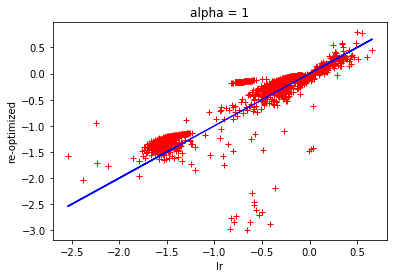

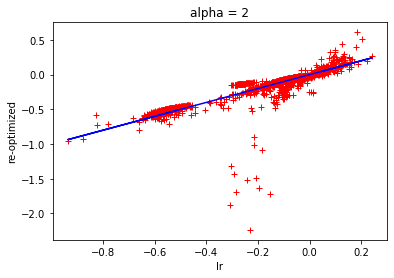

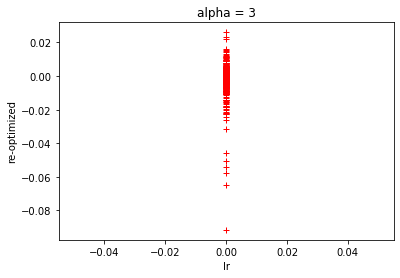

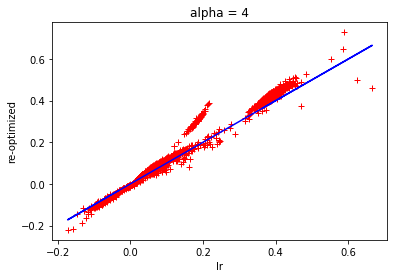

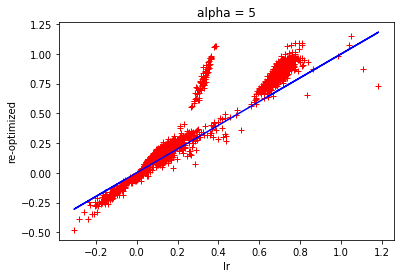

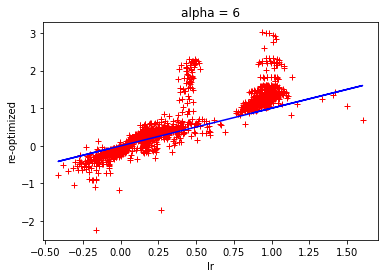

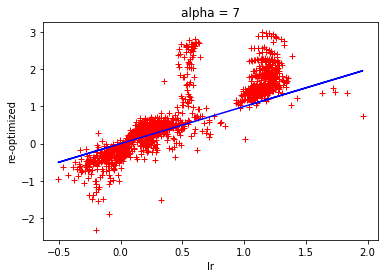

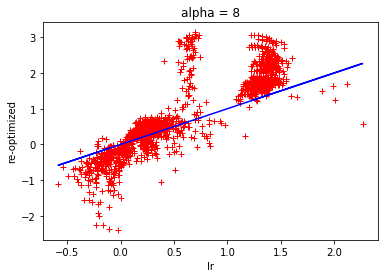

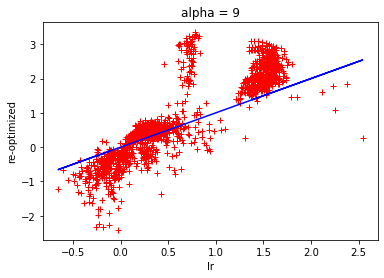

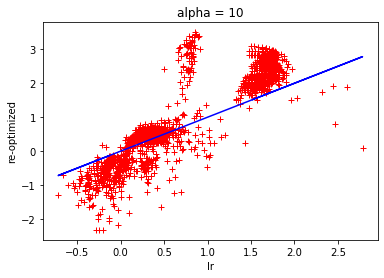

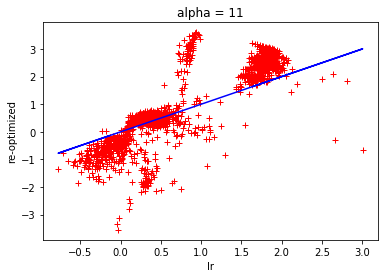

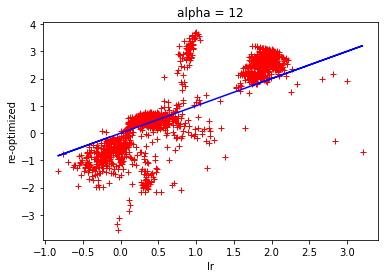

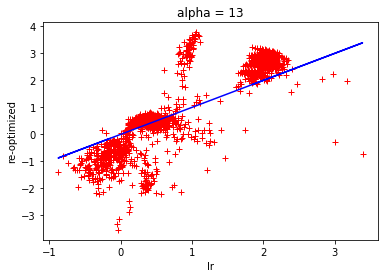

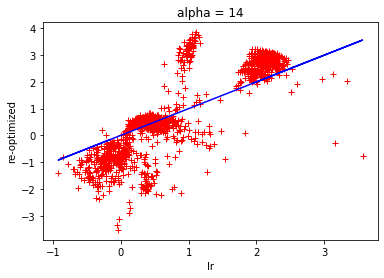

In [46]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))


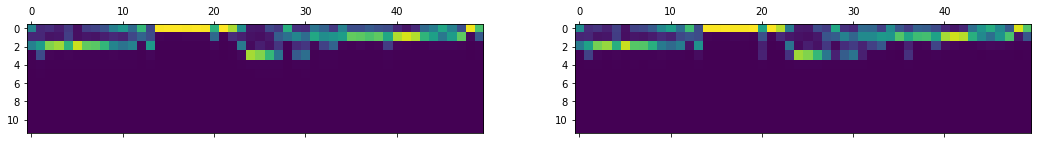

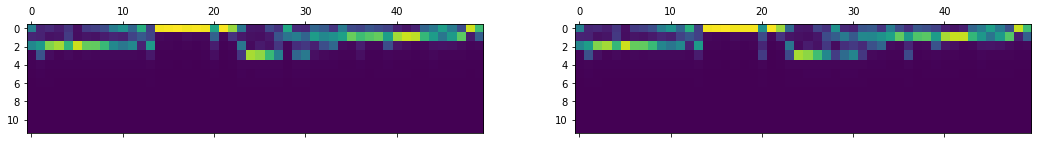

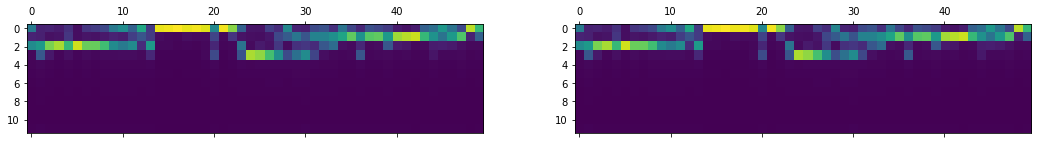

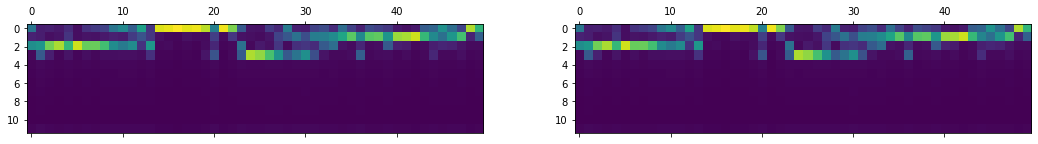

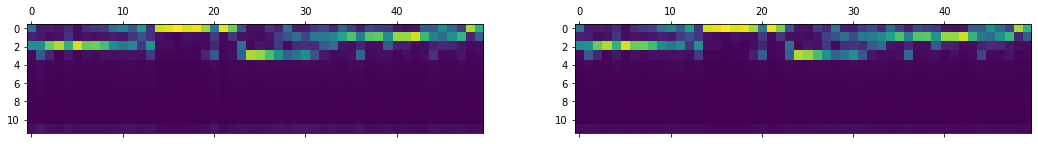

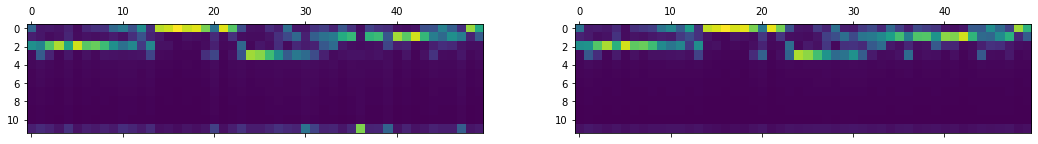

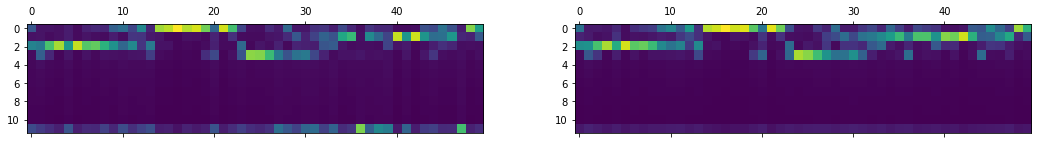

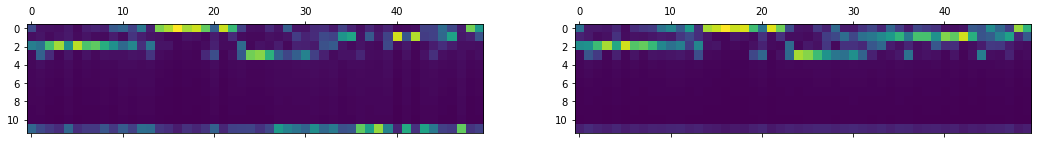

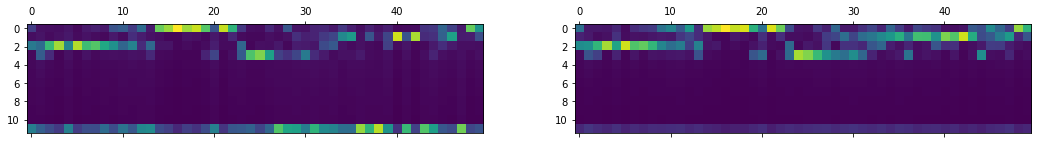

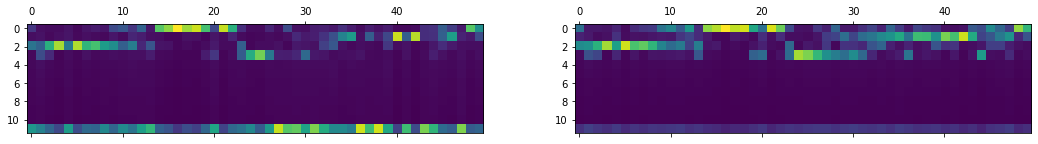

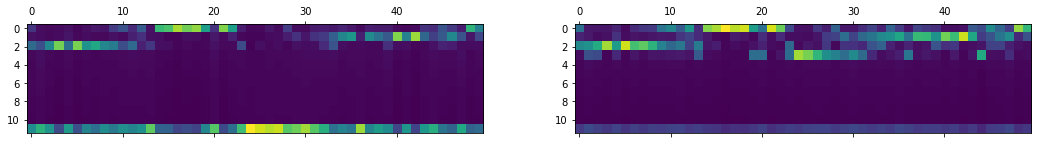

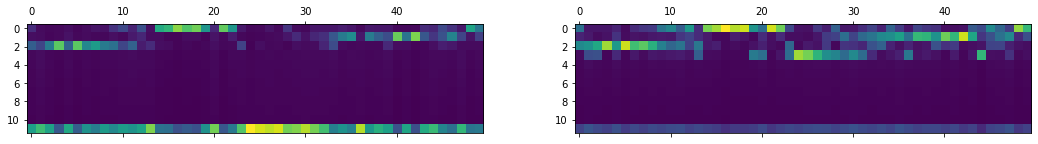

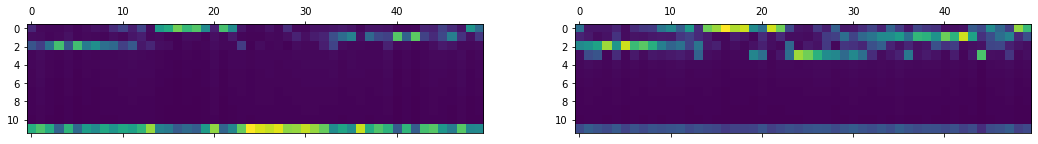

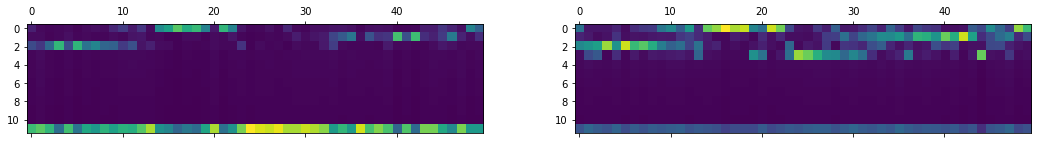

In [47]:
for i in range(len(alpha_list)): 

    fig, axes = plt.subplots(1, 2, figsize = (18, 4))

    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    
    axes[0].matshow(get_vb_expectations(pert_dict, use_logitnormal_sticks)[0].transpose())
    axes[1].matshow(get_vb_expectations(lr_dict, use_logitnormal_sticks)[0].transpose())


### Examine expected number of clusters

In [48]:
n_samples = 10000
unif_samples = np.random.random((n_obs, n_samples))

threshold = 0

In [49]:
e_num_clusters_lr = np.zeros(len(alpha_list))
e_num_clusters_pert = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)

    # these are individual belongings
    pert_e_ind_admix, _ = get_vb_expectations(pert_dict, use_logitnormal_sticks)
    
    lr_e_ind_admix, _ = get_vb_expectations(lr_dict, use_logitnormal_sticks)
    
    # get expected number of clusters
    
    # this isn't quite right : we are treating the individual admixtures like multinomial probabilities, 
    # not a stick-breaking process
    e_num_clusters_lr[i] = cluster_quantities_lib.get_e_num_large_clusters_from_ez(lr_e_ind_admix,
                                threshold,
                                unif_samples = unif_samples)[0]
    
    e_num_clusters_pert[i] = cluster_quantities_lib.get_e_num_large_clusters_from_ez(pert_e_ind_admix,
                                threshold,
                                unif_samples = unif_samples)[0]

In [50]:
lr_e_ind_admix.shape

(50, 12)

Text(0, 0.5, 'expected number of clusters')

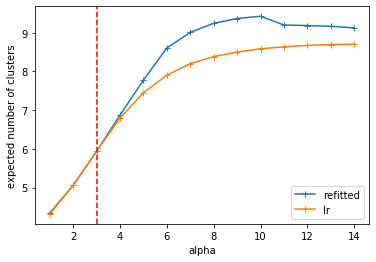

In [51]:
plt.plot(alpha_list, e_num_clusters_pert, '+-')
plt.plot(alpha_list, e_num_clusters_lr, '+-')

plt.axvline(x = prior_params_dict['dp_prior_alpha'], linestyle = '--', color = 'r')

plt.legend(('refitted', 'lr'))

plt.xlabel('alpha')
plt.ylabel('expected number of clusters')